# Exercise 3

Train a ResNet such that:
* when provided with an input MNIST image, is expected to produce an output image of the same shape
* this output image should depict the successive number with respect to the input

In [8]:
import torch
import torchvision
import random
from tqdm import trange, tqdm
from matplotlib import pyplot as plt

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

In [9]:
train_mnist = torchvision.datasets.MNIST(
    "./data",
    train=True,
    download=True,
    transform=torchvision.transforms.Compose([
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Normalize((0.1307,), (0.3081,))
    ])
)

test_mnist = torchvision.datasets.MNIST(
    "./data",
    train=False,
    download=True,
    transform=torchvision.transforms.Compose([
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Normalize((0.1307,), (0.3081,))
    ])
)

In [10]:
class FollowingNumber(torch.utils.data.IterableDataset):
    def __init__(self, dataset):
        super().__init__()
        self.dataset = dataset

    def __iter__(self):
        return self

    def __next__(self):
        a_digit, a_class = random.choice(self.dataset)
        while a_class == 9:
            a_digit, a_class = random.choice(self.dataset)
        
        b_digit, b_class = random.choice(self.dataset)
        while b_class != a_class + 1:
            b_digit, b_class = random.choice(self.dataset)

        return a_digit, b_digit

## Model Implementation

In [11]:
class ResidualBlock(torch.nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()

        self.conv1 = torch.nn.Sequential(
            torch.nn.Conv2d(
                in_channels, out_channels,
                kernel_size=3, padding=1
            ),
            torch.nn.BatchNorm2d(out_channels),
            torch.nn.ReLU()
        )

        self.conv2 = torch.nn.Sequential(
            torch.nn.Conv2d(
                out_channels, out_channels,
                kernel_size=3, padding=1
            ),
            torch.nn.BatchNorm2d(out_channels),
        )
        
        self.downsample = None
        if in_channels != out_channels:
            self.downsample = torch.nn.Sequential(
                torch.nn.Conv2d(
                    in_channels, out_channels,
                    kernel_size=1, stride=1
                ),
                torch.nn.BatchNorm2d(out_channels),
            )
    
    def forward(self, x):
        y = self.conv1(x)
        y = self.conv2(y)

        if self.downsample is not None:
            out = self.downsample(x) + y
        else:
            out = x + y

        return torch.relu(out)

In [12]:
class ResNet(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.net = torch.nn.Sequential(
            ResidualBlock(1, 16),
            ResidualBlock(16, 32),
            ResidualBlock(32, 64),
            ResidualBlock(64, 64),
            ResidualBlock(64, 64),
            ResidualBlock(64, 64),
            ResidualBlock(64, 32),
            ResidualBlock(32, 16),
            ResidualBlock(16, 1),
        )
    
    def forward(self, x):
        return self.net(x)

## Train the Model

In [ ]:
batches = 1000
ds = FollowingNumber(train_mnist)
dl = torch.utils.data.DataLoader(ds, batch_size=32)

model = ResNet()
model = model.to(DEVICE)

loss_fn = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

loss_history = []

for epoch in range(3):
    bar = tqdm(enumerate(dl), total=batches)
    for i, (a, b) in bar:
        a = a.to(DEVICE)
        b = b.to(DEVICE)

        optimizer.zero_grad()
        out = model(a)
        loss = loss_fn(out, b)

        loss.backward()
        optimizer.step()

        bar.set_description(f"Loss {loss.item():.4f}")

        if i >= batches:
            break
            
        if i % 30 == 0:
            loss_history.append(loss.item())

plt.plot(loss_history)
plt.show()

Loss 0.7016:  56%|█████▌    | 556/1000 [19:31<02:24,  3.07it/s]    

## Test the Model

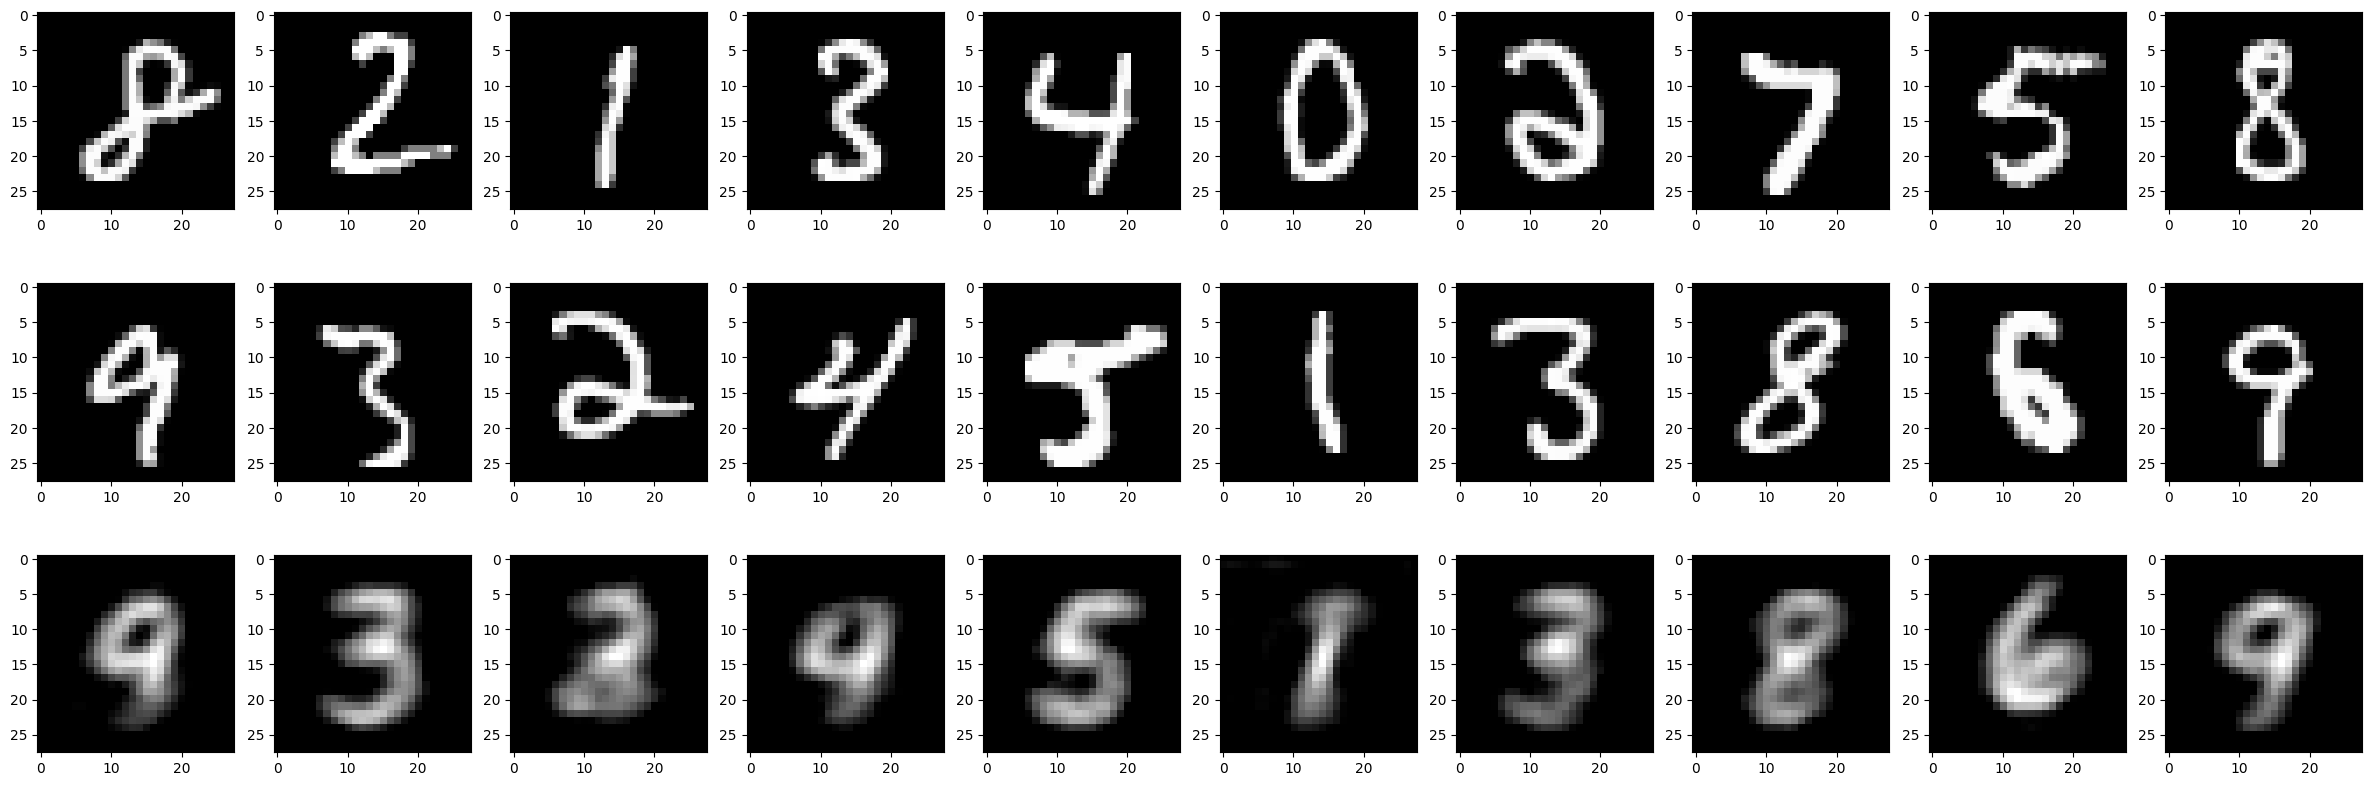

In [15]:
from matplotlib import pyplot as plt
%matplotlib inline

ds = FollowingNumber(test_mnist)

fig, axes = plt.subplots(3, 10, figsize=(30, 10))

for i, (a, b) in zip(range(0, 10), ds):
    a = a.to(DEVICE)
    b = b.to(DEVICE)
    
    out = model(a.unsqueeze(0))

    axes[0, i].imshow(a[0].cpu().numpy(), cmap="gray")
    
    axes[1, i].imshow(b[0].cpu().numpy(), cmap="gray")
    axes[2, i].imshow(out[0, 0].detach().cpu().numpy(), cmap="gray")

plt.show()